###### In this case, we have a very interesting problem: classification of an unbalanced data set with a large number of missing values.

So there are two files:

tracks - information about each ride
os - phone operating system information



Our goal is to predict whether the user was in the passenger seat or in the driver's seat. We also have a class 'taxi', which shows that the user called a taxi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report

pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
os = pd.read_csv('os.csv', sep=',', header=0)

In [3]:
tracks = pd.read_csv('rich_tracks_2.csv', sep=',', header=0)

### OS wrangling

In [4]:
os.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Columns: 2 entries, DeviceToken to os_version
dtypes: object(2)
memory usage: 69.1+ KB


In [5]:
os.head()

,DeviceToken,os_version
0,2A768BE9-24E4-4274-AE30-03D07EE1D5B8,Android
1,CA447E48-E1C4-4F06-BA03-35C029C7E0F8,Android
2,EB26DDE2-8C75-439B-8FDA-AE838E15E944,iOS
3,3135D84F-1A08-4CBF-9439-D6C1BA58F4AA,iOS
4,16B59F05-9FEC-40DA-A181-C42B1AA2B517,Android


In [6]:
os['os_version'].value_counts()

Android    2314
iOS        2102
Name: os_version, dtype: int64

In [7]:
os.isna().sum().sort_values(ascending=False).head()

os_version     0
DeviceToken    0
dtype: int64

It's looking good!

### Tracks wrangling

In [8]:
tracks.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 64 entries, Id to DeviationMeters
dtypes: bool(2), float64(44), int64(5), object(13)
memory usage: 1.9+ MB


In [9]:
tracks['TrackOrigin'].value_counts()

OriginalDriver    2000
Passanger         1678
Taxi               322
Name: TrackOrigin, dtype: int64

Unbalance of classes are: 6.21:5.21:1 

In [10]:
tracks.isna().sum().sort_values(ascending=False).head(20)

BeaconId               4000
VehicleId              4000
Prediction             4000
RatingCornering        2792
OriginalTrackOrigin    2000
KAcceleration          1208
KDeceleration          1208
Region                 1176
DeviationMeters        1055
DeviationRatio         1055
KPhoneUsage            1008
KTimeOfDay             1008
KOverSpeed             1008
CityStart                 1
CityFinish                1
AddressFinish             1
Country                   1
AddressStart              1
RatingOverSpeed           0
Urban                     0
dtype: int64

And a lot of missing values. Ok, as first let's drop columns with duplicate and only NA values:

In [11]:
tracks.drop(['BeaconId','VehicleId', 'Prediction', 'OriginalTrackOrigin'], axis = 1, inplace = True)

In [12]:
tracks.drop(['UpdateDT'], axis = 1, inplace = True) # technical information that we don't need

I also need to drop columns with address, because:

    1) We have all other information. 
    2) It is probably not so important to predict our target values 
    3) To avoid problems with personal data)

In [13]:
tracks.drop(['AddressStart','AddressFinish'], axis = 1, inplace = True)

And a row without info about country:

In [14]:
tracks.drop(tracks[tracks.Country.isna()].index[0], inplace=True)
tracks.reindex(index=range(0, len(tracks.Id)))
print('Entry was deleted.')

Entry was deleted.


Let us see on missing values in 'RatingCornering':

In [15]:
tracks[tracks['RatingCornering'].isna() == False]['TrackOrigin'].value_counts()

Passanger         910
OriginalDriver    298
Name: TrackOrigin, dtype: int64

For not NA-values there are no entries with TrackOrigin = 'Taxi'. Can it be accidentally?

Which part of our dataset consist of 'Taxi'?

In [16]:
tracks[tracks['TrackOrigin']=='Taxi']['TrackOrigin'].count()/tracks['TrackOrigin'].count()

0.08052013003250813

8%! But in our case, there are 1208 entries where “RatingCornering” has a non-null value. This means that it is no coincidence, and we can fill these NA.

In [17]:
tracks[tracks['RatingCornering'] > 0]['RatingCornering'].value_counts()

5.0    1097
1.0      61
4.0      21
3.0      12
2.0       7
Name: RatingCornering, dtype: int64

I think zero is good choice for that.

In [18]:
tracks.loc[tracks['TrackOrigin']=='Taxi','RatingCornering'] = tracks.loc[tracks['TrackOrigin']=='Taxi','RatingCornering'].fillna(value=0)

Now let us see to the other two categories:

In [19]:
tracks[tracks['TrackOrigin'] == 'OriginalDriver']['RatingCornering'].value_counts()

5.0    284
1.0      9
4.0      4
3.0      1
Name: RatingCornering, dtype: int64

In [20]:
tracks[tracks['TrackOrigin'] == 'Passanger']['RatingCornering'].value_counts()

5.0    813
1.0     52
4.0     17
3.0     11
0.0     10
2.0      7
Name: RatingCornering, dtype: int64

Almost all rows, marked as 'OriginalDriver', has 5 in RatingCornering and we can count the other 13 values as outliers. But for 'Passanger' situation is another. We can not use the median value, because there is skewness in data. So it can be reasonable to fill NA-values with mean.

In [21]:
tracks.loc[tracks['TrackOrigin']=='OriginalDriver','RatingCornering'] = tracks.loc[tracks['TrackOrigin']=='OriginalDriver','RatingCornering'].fillna(value=5)

In [22]:
mean_value = tracks[tracks['TrackOrigin'] == 'Passanger']['RatingCornering'].mean()
tracks.loc[tracks['TrackOrigin']=='Passanger','RatingCornering'] = tracks.loc[tracks['TrackOrigin']=='Passanger','RatingCornering'].fillna(value=mean_value)

In [23]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 3999
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      3999 non-null   int64  
 1   TrackToken              3999 non-null   object 
 2   DeviceToken             3999 non-null   object 
 3   IncomingTrackId         3999 non-null   int64  
 4   StartDate               3999 non-null   object 
 5   EndDate                 3999 non-null   object 
 6   Distance                3999 non-null   float64
 7   Duration                3999 non-null   float64
 8   AccelerationCount       3999 non-null   int64  
 9   DecelerationCount       3999 non-null   int64  
 10  Rating                  3999 non-null   float64
 11  PhoneUsage              3999 non-null   float64
 12  TrackOrigin             3999 non-null   object 
 13  OriginChanged           3999 non-null   bool   
 14  DistanceGPS             3999 non-null   

In [24]:
tracks_numbers = tracks.drop(['Id', 'TrackToken', 'DeviceToken', 'IncomingTrackId', 'StartDate', 'EndDate', 'TrackOrigin', 'Region', 'Country', 'CityStart', 'CityFinish'], axis = 1).copy()

IterativeImputer will help us to fill the missing values while maintaining distribution characteristics.

In [25]:
it_imp = IterativeImputer(max_iter=10000)

In [26]:
tracks_new = pd.DataFrame(data =it_imp.fit_transform(tracks_numbers), columns = tracks_numbers.columns)

In [27]:
# We also need to normalize coeffitient values, what more than 1:
# KOverSpeed, KAcceleration, KTimeOfDay, KDeceleration, KPhoneUsage

for i in tracks_new[tracks_new.KOverSpeed >1].index:
    tracks_new.iloc[i,21] = 1
for i in tracks_new[tracks_new.KAcceleration >1].index:
        tracks_new.iloc[i,22] = 1
for i in tracks_new[tracks_new.KTimeOfDay >1].index:
        tracks_new.iloc[i,23] = 1
for i in tracks_new[tracks_new.KDeceleration >1].index:
        tracks_new.iloc[i,24] = 1
for i in tracks_new[tracks_new.KPhoneUsage >1].index:
        tracks_new.iloc[i,30] = 1

In [28]:
tracks = tracks[['Id', 'TrackToken', 'DeviceToken', 'IncomingTrackId', 'StartDate', 'EndDate', 'TrackOrigin', 'Region', 'Country', 'CityStart', 'CityFinish']]
tracks = tracks.join(tracks_new, how='inner')

'Shared' has only 0-values, so we can drop it:

In [29]:
tracks.drop('Shared',axis = 1, inplace = True)

## Feature engineering

As first we can add a os_version. For these we need reindex our dataset on Device token:

In [30]:
tracks = tracks.set_index('DeviceToken').join(os.set_index('DeviceToken'))

As we have start and finish city, it can be worth to mark intercity trips.

In [31]:
tracks['is_intercity'] = 0
tracks['year'] = 0
tracks['dayofyear'] = 0
tracks['quarter'] = 0
tracks['month'] = 0
tracks['days_in_month'] = 0
tracks['weekofyear'] = 0
tracks['dayofweek'] = 0
tracks['day'] = 0
tracks['hour'] = 0
tracks['is_month_end'] = 0
tracks['is_month_start'] = 0
tracks['is_quarter_end'] = 0
tracks['is_quarter_start'] = 0
tracks['is_year_end'] = 0
tracks['is_year_start'] = 0

for row in range(0, tracks.count()[0]):
    if tracks.iloc[row, 8] != tracks.iloc[row, 9]:
        tracks.iloc[row,-16] = 1
        
    tracks.iloc[row,-15] = pd.to_datetime(tracks.iloc[row,3]).year
    tracks.iloc[row,-14] = pd.to_datetime(tracks.iloc[row,3]).dayofyear
    tracks.iloc[row,-13] = pd.to_datetime(tracks.iloc[row,3]).quarter
    tracks.iloc[row,-12] = pd.to_datetime(tracks.iloc[row,3]).month
    tracks.iloc[row,-11] = pd.to_datetime(tracks.iloc[row,3]).days_in_month
    tracks.iloc[row,-10] = pd.to_datetime(tracks.iloc[row,3]).weekofyear
    tracks.iloc[row,-9] = pd.to_datetime(tracks.iloc[row,3]).dayofweek
    tracks.iloc[row,-8] = pd.to_datetime(tracks.iloc[row,3]).day
    tracks.iloc[row,-7] = pd.to_datetime(tracks.iloc[row,3]).hour
    
    if pd.to_datetime(tracks.iloc[row,3]).is_month_end == True:
        tracks.iloc[row,-6] = 1
    if pd.to_datetime(tracks.iloc[row,3]).is_month_start == True:
        tracks.iloc[row,-5] = 1
    if pd.to_datetime(tracks.iloc[row,3]).is_quarter_end == True:
        tracks.iloc[row,-4] = 1
    if pd.to_datetime(tracks.iloc[row,3]).is_quarter_start == True:
        tracks.iloc[row,-3] = 1        
    if pd.to_datetime(tracks.iloc[row,3]).is_year_end == True:
        tracks.iloc[row,-2] = 1
    if pd.to_datetime(tracks.iloc[row,3]).is_year_start == True:
        tracks.iloc[row,-1] = 1   
    row+=1

In [32]:
tracks.iloc[:,-16:].describe()

,is_intercity,year,dayofyear,quarter,month,days_in_month,weekofyear,dayofweek,day,hour,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
count,4037.000000,4037.0,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.000000,4037.0,4037.0
mean,0.199901,2019.0,278.905871,3.740649,9.665346,30.810007,40.380481,3.242507,16.020808,13.913550,0.004706,0.002973,0.004706,0.002973,0.0,0.0
std,0.399975,0.0,19.792959,0.438333,0.620688,0.392344,2.859684,1.472542,5.679503,4.666606,0.068451,0.054446,0.068451,0.054446,0.0,0.0
min,0.000000,2019.0,196.000000,3.000000,7.000000,30.000000,29.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.000000,2019.0,272.000000,3.000000,9.000000,31.000000,39.000000,3.000000,15.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,0.000000,2019.0,290.000000,4.000000,10.000000,31.000000,42.000000,3.000000,17.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,0.000000,2019.0,290.000000,4.000000,10.000000,31.000000,42.000000,4.000000,17.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,1.000000,2019.0,296.000000,4.000000,10.000000,31.000000,43.000000,6.000000,30.000000,23.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


Now we can drop useless columns without any information for us:

In [33]:
tracks = tracks.drop(['Id','Region','TrackToken','IncomingTrackId','StartDate','EndDate','CityFinish','year','is_year_end','is_year_start'], axis =1)

Countries and Cities must be replaced with numbers:

In [34]:
country_labels = tracks.Country.unique()
country_dict = dict(zip(country_labels, range(len(country_labels))))
tracks = tracks.replace({"Country": country_dict})

In [35]:
city_labels = tracks.CityStart.unique()
city_dict = dict(zip(city_labels, range(len(city_labels))))
tracks = tracks.replace({"CityStart": city_dict})

In [36]:
tracks.TrackOrigin = tracks.TrackOrigin.map({'OriginalDriver':1, 'Passanger':2,'Taxi':3})
tracks.os_version = tracks.os_version.map({'Android':1,'iOS':2}, na_action='ignore')
tracks.os_version.fillna('3',inplace=True)
tracks.os_version = tracks.os_version.astype('int')

### Now, our dataset is ready to ML!

Our purpose is tracks classification. Lets take a look on categories balance:

In [37]:
tracks.TrackOrigin.value_counts()

1    2005
2    1708
3     324
Name: TrackOrigin, dtype: int64

As a predictions metric, I would use 'balanced_accuracy' because it's a good choice for the same imbalanced datasets. Let us run a GBClassifier (because of it fast and accurate), just to see results.

In [38]:
y = tracks.TrackOrigin
X = tracks.drop('TrackOrigin', axis = 1)

In [39]:
gbc = GradientBoostingClassifier(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
model = gbc.fit(X_train, y_train)
print(classification_report(y_test,model.predict(X_test)))
print('Balanced acc.score:',balanced_accuracy_score(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       611
           2       0.89      0.92      0.90       512
           3       0.42      0.34      0.37        89

    accuracy                           0.92      1212
   macro avg       0.77      0.75      0.76      1212
weighted avg       0.91      0.92      0.91      1212

Balanced acc.score: 0.7516824672284644


In [40]:
pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False).transpose()

,OriginChanged,Country,CityStart,day,hour,dayofyear,DeviationRatio,AccelerationIDuration,Distance,MaxSpeed,AverageSpeed,dayofweek,DeviationMeters,MidOverSpeedMileage,AccelerationICount,KOverSpeed,Duration,KDeceleration,EcoScoring,os_version,DailyHours,RatingCornering,HighOverSpeedMileage,OverSpeedMileage,PhoneUsageKm,RatingPhoneUsage,NightHours,DecelerationICount,RatingDeceleration,DistanceGPS,DecelerationIDuration,EcoScoringTyres,RatingAcceleration,Rating,RushHours,RatingOverSpeed,KAcceleration,RatingTimeOfDay,CompanyId,PhoneUsage,EcoScoringDepreciation,CorneringDuration,weekofyear,PhoneUsageOverSpeedKm,DecelerationCount,is_month_start,days_in_month,month,is_quarter_start,quarter,PhoneUsageOverSpeed,AccelerationCount,is_intercity,Urban,CorneringCount,is_quarter_end,is_month_end,EcoScoringFuel,KTimeOfDay,KPhoneUsage,EcoScoringBrakes
Importance,0.823746,0.059929,0.016537,0.00933,0.00918,0.007858,0.007097,0.004745,0.004265,0.00413,0.004028,0.003616,0.003063,0.002755,0.002605,0.002559,0.002518,0.002319,0.002144,0.002081,0.001774,0.001718,0.001688,0.001584,0.001424,0.001328,0.001242,0.001232,0.001188,0.001154,0.001017,0.000928,0.000845,0.000828,0.000796,0.000793,0.000727,0.000705,0.000556,0.00051,0.000486,0.00044,0.000423,0.000405,0.000355,0.000307,0.000155,0.000154,0.000146,0.00013,0.000116,0.00009,0.000086,0.00007,0.000043,0.000027,0.000016,0.000006,0.000001,4.927246e-10,0.0


Not so bad, but what happens, if we apply undersampling to balance our classes?

In [41]:
tracks_sorted = tracks.sort_values(by='TrackOrigin')

In [42]:
df_driver  = tracks_sorted.iloc[:2005,:].sample(324)
df_passanger  = tracks_sorted.iloc[2005:3713,:].sample(324)
df_taxi = tracks_sorted.iloc[3713:,:]
tracks_balanced = pd.concat([df_driver, df_passanger, df_taxi])
tracks_balanced.TrackOrigin.value_counts()

3    324
2    324
1    324
Name: TrackOrigin, dtype: int64

In [43]:
y = tracks_balanced.TrackOrigin
X = tracks_balanced.drop('TrackOrigin', axis = 1)
gbc = GradientBoostingClassifier(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
model = gbc.fit(X_train, y_train)
print(classification_report(y_test,model.predict(X_test)))
print('Balanced acc.score:',balanced_accuracy_score(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        95
           2       0.81      0.60      0.69       105
           3       0.65      0.84      0.73        92

    accuracy                           0.80       292
   macro avg       0.82      0.81      0.81       292
weighted avg       0.82      0.80      0.80       292

Balanced acc.score: 0.8123188405797102


In [44]:
pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False).transpose()

,OriginChanged,Country,CityStart,day,DeviationRatio,hour,AccelerationIDuration,DeviationMeters,OverSpeedMileage,dayofweek,dayofyear,DecelerationICount,KOverSpeed,Duration,Distance,AverageSpeed,KDeceleration,MaxSpeed,KAcceleration,DailyHours,AccelerationICount,os_version,RushHours,PhoneUsageKm,DistanceGPS,NightHours,MidOverSpeedMileage,RatingDeceleration,DecelerationCount,DecelerationIDuration,RatingAcceleration,HighOverSpeedMileage,Rating,EcoScoring,PhoneUsageOverSpeed,PhoneUsage,weekofyear,RatingTimeOfDay,RatingCornering,RatingOverSpeed,quarter,EcoScoringTyres,AccelerationCount,PhoneUsageOverSpeedKm,CompanyId,EcoScoringDepreciation,CorneringDuration,is_intercity,is_quarter_start,is_month_start,Urban,RatingPhoneUsage,EcoScoringFuel,CorneringCount,month,days_in_month,is_quarter_end,KPhoneUsage,KTimeOfDay,EcoScoringBrakes,is_month_end
Importance,0.582726,0.197607,0.021336,0.015153,0.014473,0.014092,0.013496,0.010622,0.008548,0.008271,0.008255,0.00738,0.007342,0.00724,0.00667,0.00611,0.005514,0.005044,0.004586,0.004395,0.004158,0.003648,0.003346,0.003179,0.003089,0.003073,0.002896,0.002704,0.002593,0.002455,0.002351,0.002062,0.001986,0.00173,0.001675,0.001626,0.001556,0.001349,0.001297,0.000597,0.000568,0.000438,0.000424,0.000416,0.000415,0.000345,0.000261,0.000179,0.000168,0.000158,0.000117,0.000115,0.000102,0.000051,0.000012,0.000001,7.556155e-10,0.0,0.0,0.0,0.0


What if we increase the number of samples, allowing a slight imbalance between the groups?

In [45]:
df_driver  = tracks_sorted.iloc[:2005,:].sample(550)
df_passanger  = tracks_sorted.iloc[2005:3713,:].sample(550)
df_taxi = tracks_sorted.iloc[3713:,:]
tracks_balanced = pd.concat([df_driver, df_passanger, df_taxi])
tracks_balanced.TrackOrigin.value_counts()
y = tracks_balanced.TrackOrigin
X = tracks_balanced.drop('TrackOrigin', axis = 1)
gbc = GradientBoostingClassifier(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
model = gbc.fit(X_train, y_train)
print(classification_report(y_test,model.predict(X_test)))
print('Balanced acc.score:',balanced_accuracy_score(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       162
           2       0.80      0.78      0.79       174
           3       0.60      0.64      0.62        92

    accuracy                           0.83       428
   macro avg       0.80      0.81      0.80       428
weighted avg       0.83      0.83      0.83       428

Balanced acc.score: 0.8057221389305348


In [46]:
pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False).transpose()

,OriginChanged,Country,CityStart,day,hour,AverageSpeed,dayofyear,DeviationMeters,MaxSpeed,CorneringDuration,dayofweek,DeviationRatio,Duration,RatingAcceleration,AccelerationIDuration,RushHours,AccelerationICount,os_version,HighOverSpeedMileage,RatingPhoneUsage,Rating,PhoneUsageKm,DecelerationICount,DistanceGPS,Distance,RatingCornering,NightHours,PhoneUsage,OverSpeedMileage,KAcceleration,RatingOverSpeed,MidOverSpeedMileage,DecelerationIDuration,KOverSpeed,KDeceleration,EcoScoringDepreciation,RatingDeceleration,is_intercity,DailyHours,RatingTimeOfDay,EcoScoring,CompanyId,weekofyear,EcoScoringTyres,PhoneUsageOverSpeed,AccelerationCount,Urban,PhoneUsageOverSpeedKm,DecelerationCount,quarter,CorneringCount,month,days_in_month,is_month_start,EcoScoringFuel,EcoScoringBrakes,KTimeOfDay,is_month_end,KPhoneUsage,is_quarter_end,is_quarter_start
Importance,0.635037,0.162631,0.032337,0.026811,0.011901,0.010226,0.009401,0.007234,0.006875,0.005898,0.005333,0.004948,0.004856,0.004775,0.004539,0.004139,0.004063,0.004036,0.003923,0.003797,0.003366,0.003274,0.003267,0.003055,0.003002,0.002895,0.002671,0.002654,0.002388,0.002236,0.002088,0.001767,0.001682,0.001617,0.001608,0.001397,0.001272,0.001224,0.001209,0.00088,0.000833,0.000602,0.000551,0.000488,0.00027,0.000263,0.000197,0.000104,0.000092,0.000075,0.000072,0.000056,0.000046,0.00003,0.000006,0.0,0.0,0.0,0.0,0.0,0.0


I think we can to drop KPhoneUsage, KTimeOfDay, EcoScoringBrakes.

In [47]:
tracks_sorted.drop(['KTimeOfDay','KPhoneUsage', 'EcoScoringBrakes'], axis = 1, inplace=True)

Now we can detect best balance between classes:

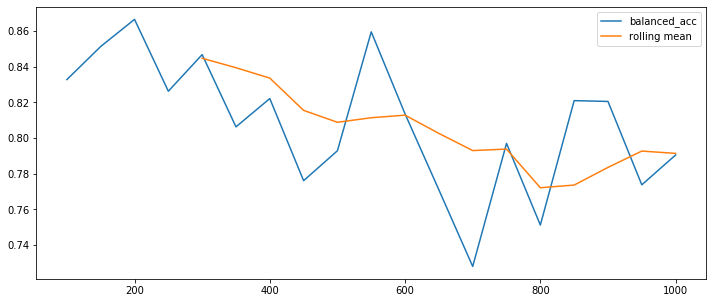

In [48]:
x_points = []
y_points = []
for i in range(100,1001,50):
    df_driver  = tracks_sorted.iloc[:2005,:].sample(i)
    df_passanger  = tracks_sorted.iloc[2005:3713,:].sample(i)
    df_taxi = tracks_sorted.iloc[3713:,:]
    tracks_balanced = pd.concat([df_driver, df_passanger, df_taxi])
    tracks_balanced.TrackOrigin.value_counts()
    y = tracks_balanced.TrackOrigin
    X = tracks_balanced.drop('TrackOrigin', axis = 1)
    gbc = GradientBoostingClassifier(n_estimators=1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    model = gbc.fit(X_train, y_train)
    x_points.append(i)
    y_points.append(balanced_accuracy_score(y_test,model.predict(X_test)))
    
plt.figure(figsize=(12, 5))
plt.plot(x_points, y_points, label ='balanced_acc')
plt.plot(x_points, pd.Series(y_points).rolling(window=5).mean(), label='rolling mean')
plt.legend()
plt.show()

As we can see, the best result is achieved with a sample size in range (300; 450). I have chosen 375 as a means.

### Data scaling and splitting

In [49]:
df_driver  = tracks_sorted.iloc[:2005,:].sample(375)
df_passanger  = tracks_sorted.iloc[2005:3713,:].sample(375)
df_taxi = tracks_sorted.iloc[3713:,:]
tracks_balanced = pd.concat([df_driver, df_passanger, df_taxi])
tracks_balanced.TrackOrigin.value_counts()
y = tracks_balanced.TrackOrigin
X = tracks_balanced.drop('TrackOrigin', axis = 1)
X_scaled = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)

I used MinMaxScaler because there are no many outliers.

## Model Selection

In [50]:
gbc = GradientBoostingClassifier()
params = {'n_estimators':[1000,2000]}
model = GridSearchCV(gbc, param_grid=params, scoring='balanced_accuracy', cv=KFold(n_splits=15, shuffle = True), n_jobs=-1)
model.fit(X_train, y_train)
print('GradientBoostingClassifier:')
print('best_score_:{}'.format(model.best_score_))
print('best_params_:{}'.format(model.best_params_))

rfc = RandomForestClassifier()
params = {'n_estimators':[1000,2000]}
model = GridSearchCV(rfc, param_grid=params, scoring='balanced_accuracy', cv=KFold(n_splits=15, shuffle = True), n_jobs=-1)
model.fit(X_train, y_train)
print('RandomForestClassifier:')
print('best_score_:{}'.format(model.best_score_))
print('best_params_:{}'.format(model.best_params_))

etc = ExtraTreesClassifier()
params = {'n_estimators':[1000,2000]}
model = GridSearchCV(etc, param_grid=params, scoring='balanced_accuracy', cv=KFold(n_splits=15, shuffle = True), n_jobs=-1)
model.fit(X_train, y_train)
print('ExtraTreesClassifier:')
print('best_score_:{}'.format(model.best_score_))
print('best_params_:{}'.format(model.best_params_))

GradientBoostingClassifier:
best_score_:0.8363475293611696
best_params_:{'n_estimators': 2000}
RandomForestClassifier:
best_score_:0.8259473203792763
best_params_:{'n_estimators': 1000}
ExtraTreesClassifier:
best_score_:0.7899866013281905
best_params_:{'n_estimators': 1000}


RandomForestClassifier has a best score! Nice, now we need to tune hyperparameters.

### Model tuning

In [51]:
rfc = RandomForestClassifier()
params = {'n_estimators':[2000,2500,3000], 'min_samples_split':[2,3,4], 'min_samples_leaf':[2,3,4], 'max_features':['auto','log2']}
model = GridSearchCV(rfc, param_grid=params, scoring='balanced_accuracy', cv=KFold(n_splits=15, shuffle = True), n_jobs=-1, verbose=0)
model.fit(X_train, y_train)
print('best_score_:{}'.format(model.best_score_))
print('best_params_:{}'.format(model.best_params_))

best_score_:0.8336171930160579
best_params_:{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2000}


### Final model:

In [52]:
rfc = RandomForestClassifier(n_estimators=2500, max_features='auto', min_samples_leaf=3, 
                             min_samples_split=3, n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
print('Balanced acc.score:',balanced_accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       109
           2       0.75      0.66      0.70       117
           3       0.64      0.73      0.68        97

    accuracy                           0.80       323
   macro avg       0.80      0.80      0.79       323
weighted avg       0.80      0.80      0.80       323

Balanced acc.score: 0.7966928070020853


Thus, our final accuracy for multiple classifications is 0.8337, and for binary classification (driver or not) - 0.9915. 
This is not bad for such an unbalanced data set with missing values.

### Bonus 

As a bonus, I'll print the importances of features.

In [53]:
pd.DataFrame(data=rfc.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

,Importance
OriginChanged,0.175882
dayofyear,0.097325
Country,0.082385
day,0.068486
weekofyear,0.058041
RatingCornering,0.057534
dayofweek,0.045863
CityStart,0.026547
hour,0.026178
month,0.018984
